# Kuramoto-Shinomoto-Sakaguchi MV-SDE 
## Osservazione Output

In primis importiamo i pacchetti necessari per usare le funzioni matematiche in python.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time

Scriviamo la MV-SDE relativa al modello di Kuramoto-Shninomoto-Sakaguchi:

$$ dX_t = \left( \mathbb{E}[sen(X_t)] cos(X_t) - \mathbb{E}[cos(X_t)]sen(X_t) \right) dt + \sigma dW_t , \ \ \ X_0=x_0. $$

Da questa equazione differenziale si evince che:
* K = 3, d = 1 e q = 1,
* $\varphi(x)=(1, senx, cosx)$, 
* $\alpha(t,x)=(0, cosx, -senx)^T$, 
* $\beta(t,x)=(\sigma, 0, 0)^T$.

Siamo pronti per definire la prima funzione che applica il Metodo di Eulero a un vettore X preso in input, assieme alle costanti $c_1$ e $c_2$, il valore della parte diffusiva $\sigma$ , il numero di simulazioni M e il valore dello step temporale h.
<a id="eulero"></a>

In [2]:
def eulero(c1, c2, sigma, h, M, X):
    W = np.random.normal(0, 1, M) 
    drift = c1 * np.cos(X) - c2 * np.sin(X) 
    diffusione = sigma 
    X = X + drift * h + diffusione * math.sqrt(h) * W 
    
    return X

Ora definiamo la funzione che calcola la media degli M valori di un vettore preso in input. 
<a id="average"></a>

In [3]:
def average(Y):
    num = Y.size
    X = sum(Y) / num
    return X

Scriviamo la funzione pricipale che implementa il metodo Monte Carlo. Essa calcola il valore h di ogni step e il vettore di valori iniziali, dopodichè richiama ciclicamente il Metodo di Eulero sopra definito, per ogni step temporale.
<a id="montecarlo"></a>

In [4]:
def monte_carlo(c1, c2, a1, a2, sigma, T, N, M, X0):
    h = T / N
    X = X0 * np.ones(M)
    gamma1 = [average(np.sin(X))]
    gamma2 = [average(np.cos(X))]
    
    for i in range(N):
        X = eulero(c1 + a1 * gamma1[-1], c2 + a2 * gamma2[-1], sigma, h, M, X)
        gamma1.append(average(np.sin(X)))
        gamma2.append(average(np.cos(X)))
    
    return X, np.array(gamma1), np.array(gamma2) 

Concludiamo riportando il main che richiama le funzioni sopra definite. Ricordiamo a cosa corrisponderanno i valori che daremo in input alle funzioni che richiameremo:
* N : numero di iterazioni (steps temporali),
* M : numero di simulazioni in ogni istante,
* T : istante finale,
* $\mu$ : funzione di Drift,
* $\sigma$ : funzione di Diffuzione,
* h : step temporale,
* $X_0$ : dato iniziale.

## Confornto tempi Markoviane e McKean-Vlasov

Scriviamo la stessa funzione nel caso in cui trattiamo SDEs Markoviane. La funzione precedente è costriuita in modo da poter trattare anche questo tipo di SDES. La ridefiniamo comunque per poter controllare che i calcoli di gamma1 e gamma2 (superflui in questo caso) non affliggano troppo il tempo di esecuzione del metodo.

In [5]:
def monte_carlo_ridotto(c1, c2, sigma, T, N, M, X0):
    h = T / N
    X = X0 * np.ones(M)
    
    for i in range(N):
        X = eulero(c1, c2, sigma, h, M, X)
    
    return X

Ora vediamo il main che confronta i tempi di esecuzione dei due metodi: 1) entrambi con SDE Markoviana e 2) il primo con SDE Markoviana e il secondo con SDE di McKean-Vlasov

In [6]:
if __name__ == "__main__":
    
    # Parametri in Input
    c1 = 0
    c2 = 0
    a1 = 1
    a2 = 1
    
    sigma = 0.5
    
    T = 1
    N = 100
    M = 1000000
    X0 = 0
    
    start = time.process_time()   # parte il cronometro
    X1, gamma11, gamma21 = monte_carlo(c1, c2, 0, 0, sigma, T, N, M, X0)
    end = time.process_time()   # si ferma il cronometro
    
    print("Tempo di esecuzione SDE Markoviana con algoritmo completo: ", end - start)
    
    start = time.process_time()   # parte il cronometro
    X2, gamma12, gamma22 = monte_carlo(0, 0, a1, a2, sigma, T, N, M, X0)
    end = time.process_time()   # si ferma il cronometro
    
    print("Tempo di esecuzione SDE McKean-Vlasov con algoritmo completo: ", end - start)
    
    start = time.process_time()   # parte il cronometro
    X3 = monte_carlo_ridotto(c1, c2, sigma, T, N, M, X0)
    end = time.process_time()   # si ferma il cronometro
    
    print("Tempo di esecuzione SDE Markoviana con algoritmo ridotto: ", end - start)

Tempo di esecuzione SDE Markoviana con algoritmo completo:  62.609375
Tempo di esecuzione SDE McKean-Vlasov con algoritmo completo:  61.390625
Tempo di esecuzione SDE Markoviana con algoritmo ridotto:  15.359375


Osservazioni: 
* stranamente il secondo caso è sempre di poco più veloce del primo
* l'ultimo ci mette circa un quarto del tempo degli altri due !!! =(
* i due punti precedenti valgono nel caso c1=1, se c1=0 il secondo è poco più lento e entrambi sono circa sei volte il terzo
* se si aumenta N da 1000 a 10000, i tempi di esecuzione si moltiplicano di un fattore 10
* se si aumenta M da 10000 a 100000, il caso è analogo al precedente

In [7]:
    print("Confronto E[sen(XT)] ottenuto dai due algoritmi") 
    print('M-SDE con algoritmo completo :', gamma11[-1])
    print('MKV-SDE con algoritmo completo :', gamma12[-1])
    print('M-SDE con algoritmo ridotto :', average(np.sin(X3)))

Confronto E[sen(XT)] ottenuto dai due algoritmi
M-SDE con algoritmo completo : -0.00015045384580331342
MKV-SDE con algoritmo completo : 0.00030922526973028514
M-SDE con algoritmo ridotto : -0.00045226913472393913


## Osservazione cambiamento di M

Precisiamo anche il ruolo che le quattro costanti $c_1, \  c_2, \ a_1$ e $a_2$ hanno all'interno del programma. Esse infatti servono per rendere il metodo applicabile sia al caso di MV-SDE che a quello di SDE Markoviane. Infatti i coefficienti $a_1$ e $a_2$ possono annullare il contributo dipendente dal valore atteso,  all'interno dell'equazione.
<a id="main"></a>

In [24]:
if __name__ == "__main__":
    
    # Parametri in Input
    c1 = 0
    c2 = 0
    a1 = 1
    a2 = 1

    sigma = 0.5

    T = 1
    N = 100
    M = 1000000
    X0 = 0.5
    
    # Parametri Output che mostreremo graficamente
    crono = []
    Gamma1 = []
    Gamma2 = []

Primo ciclo in cui vediamo come cambiano $\mathbb{E}[sen(X)]$, $\mathbb{E}[cos(X)]$ e il tempo di esecuzione tenendo N fisso e aumentando il valore M del numero di simulazioni.

In [17]:
    M = range(M, M + int(M/10), int(M/10))
    
    print(" Risultati al variare di M da ", M[0], " a ", M[-1], " con c1=", c1, " c2=", c2, " a1=", a1, " a2=", a2, " T=", T, " N=", N)
    
    for i in M:
        start = time.process_time()   # parte il cronometro
        X, g1, g2 = monte_carlo(c1, c2, a1, a2, sigma, T, N, i, X0)
        end = time.process_time()   # si ferma il cronometro
        
        crono.append(end - start)
        Gamma1.append(g1)
        Gamma2.append(g2)
        
        print("Tempo di esecuzione con M=", i, " : ", crono[-1])

 Risultati al variare di M da  1000000  a  1000000  con c1= 0  c2= 0  a1= 1  a2= 1  T= 1  N= 100
Tempo di esecuzione con M= 1000000  :  63.1875


Grafico di $\mathbb{E}[sen(X)]$.

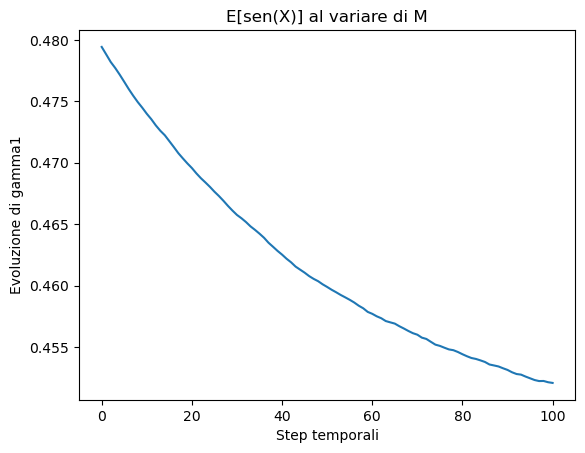

In [18]:
    fig1 = plt.figure() 
    plt.title("E[sen(X)] al variare di M") 
    plt.xlabel("Step temporali") 
    plt.ylabel("Evoluzione di gamma1") 
    # plt.ylim(-1,1) # se non c'è il grafico è molto zoomato
    for i in Gamma1:
        plt.plot(i)
    plt.show()

Grafico di $\mathbb{E}[cos(X)]$.

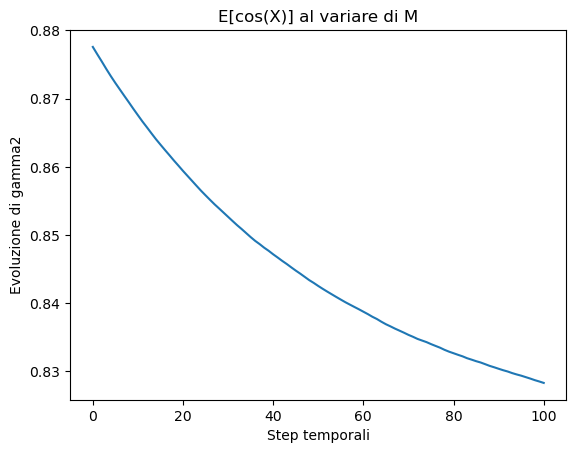

In [19]:
    fig2 = plt.figure() 
    plt.title("E[cos(X)] al variare di M") 
    plt.xlabel("Step temporali") 
    plt.ylabel("Evoluzione di gamma2") 
    # plt.ylim(-1,1)   # Se non c'è il grafico è molto zoomato
    for i in Gamma2:
        plt.plot(i)
    plt.show()

Andamento del tempo di esecuzione.

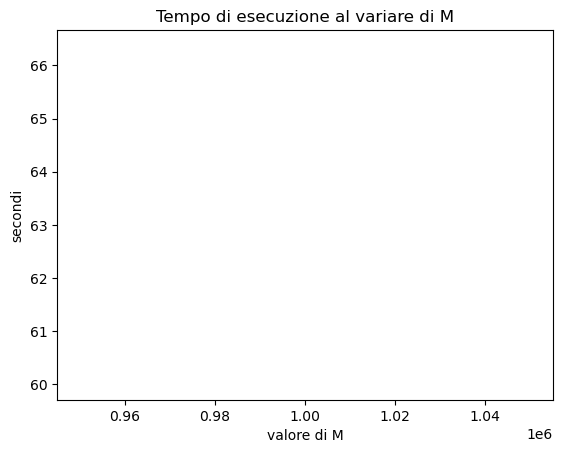

In [20]:
    fig3 = plt.figure() 
    plt.title("Tempo di esecuzione al variare di M") 
    plt.xlabel("valore di M") 
    plt.ylabel("secondi") 
    plt.plot(M, crono)
    plt.show()

Osservazioni:
* su piccola scala gli errori sono molto grandi,
* se mettiamo c1=1 gli output coincidiono anche su piccola scala, in TUTTI gli altri casi no

OSSERVAZIONI: con M più piccolo di 1 mln il grafico dei valori attesi ha un grandissimo errore relativo (ma molto piccolo quello assoluto). In particolare i grafico del seno è tutto rumore quando il dato iniziale è 0. Infine con N = 100  si hanno dei tempi accettabili però i grafici sono un poco grezzi.

## Osservazioni cambiamento di N

Azzeramento di parametri.

In [26]:
    crono = []
    Gamma1 = []
    Gamma2 = []
    
    M = 1000000
    N = range(N, N + int(N/10), int(N/10))

Secondo ciclo in cui vediamo come cambiano $\mathbb{E}[sen(X)]$, $\mathbb{E}[cos(X)]$ e il tempo di esecuzione tenendo M fisso e aumentando il valore N degli steps temporali.

In [28]:
    print(" Risultati al variare di N da ", N[0], " a ", N[-1], " con c1=", c1, " c2=", c2, " a1=", a1, " a2=", a2, " T=", T, " M=", M)
    
    for i in N:
        start = time.process_time()   # parte il cronometro
        X, g1, g2 = monte_carlo(c1, c2, a1, a2, sigma, T, i, M, X0)
        end = time.process_time()   # si ferma il cronometro
        
        crono.append(end - start)
        Gamma1.append(g1)
        Gamma2.append(g2)
        
        print("Tempo di esecuzione con N = ", i, " : ", crono[-1])

 Risultati al variare di N da  100  a  100  con c1= 0  c2= 0  a1= 1  a2= 1  T= 1  M= 1000000
Tempo di esecuzione con N =  100  :  59.875


-- NB: questi grafici sono sbagliati --

Grafico di $\mathbb{E}[sen(X)]$.

In [29]:
#    fig4 = plt.figure() 
#    plt.title("E[sen(X)] al variare di N") 
#    plt.xlabel("Step temporali") 
#    plt.ylabel("Evoluzione di gamma1") 
#    for i in Gamma1:
#        plt.plot(i)
#    plt.show()

Grafico di $\mathbb{E}[cos(X)]$.

In [30]:
#    fig5 = plt.figure() 
#    plt.title("E[cos(X)] al variare di N") 
#    plt.xlabel("Step temporali") 
#    plt.ylabel("Evoluzione di gamma2") 
#    for i in Gamma2:
#        plt.plot(i)
#    plt.show()

####

Andamento del tempo di esecuzione.

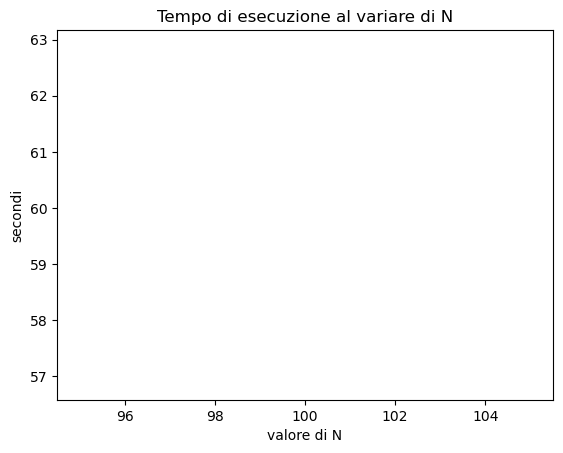

In [31]:
    fig6 = plt.figure() 
    plt.title("Tempo di esecuzione al variare di N") 
    plt.xlabel("valore di N") 
    plt.ylabel("secondi") 
    plt.plot(N, crono)
    plt.show()

[Vai alla funzione eulero](#eulero)

[Vai alla funzione average](#average)

[Vai alla funzione monte carlo](#montecarlo)

[Vai al main](#main)